In [9]:
import pickle
import torch
import os
import json

filename = "all_results/gpu_forward_pass/google_gemma-2-27b-it/score_results_v1_short_meta_job_description_google_gemma-2-27b-it_0_0_N_A_general_False.pkl"
# filename = "all_results/gpu_forward_pass/mistralai_Mistral-Small-24B-Instruct-2501/score_results_v3_short_meta_job_description_mistralai_Mistral-Small-24B-Instruct-2501_0_0_N_A_general_False.pkl"
# filename = "all_results/gpu_forward_pass/mistralai_Ministral-8B-Instruct-2410/score_results_v3_short_meta_job_description_mistralai_Ministral-8B-Instruct-2410_0_0_N_A_general_False.pkl"

with open(filename, "rb") as f:
    data = pickle.load(f)


In [2]:
print(data.keys())
print(len(data["results"]))

dict_keys(['metadata', 'results', 'bias_scores', 'bias_probs', 'summary_info', 'eval_config'])
1440


In [3]:
idx = 1
layer = 5

print(data.keys())
print(len(data["results"]))
print(data["results"][idx].keys())
print(data["results"][idx]["yes_probs"])
print(data["results"][idx]["no_probs"])
print(data["results"][idx]["activations"].keys())
print(data["results"][idx]["activations"][layer].shape)
print(data["results"][idx]["activations"][layer])
print(data["results"][idx]["gender"])

dict_keys(['metadata', 'results', 'bias_scores', 'bias_probs', 'summary_info', 'eval_config'])
1440
dict_keys(['prompt', 'system_prompt', 'task_prompt', 'resume', 'name', 'gender', 'race', 'pronouns', 'email', 'politics', 'job_category', 'pregnancy_added', 'employment_gap_added', 'political_orientation_added', 'misc_added', 'response', 'chat_completion', 'yes_probs', 'no_probs', 'activations'])
1.0
0.000667572021484375
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])
torch.Size([1, 4608])
tensor([[-0.8359, -0.9570, -0.9297,  ..., -0.7070,  0.9570,  0.4727]],
       dtype=torch.bfloat16)
Female


In [4]:
def layerwise_mean_activations(data: dict) -> tuple[torch.Tensor, torch.Tensor]:
    activation_vector = torch.zeros_like(data["results"][0]["activations"][0]).squeeze().float()

    layerwise_yes_vectors = {}
    layerwise_no_vectors = {}

    for layer in range(len(data["results"][0]["activations"])):
        layerwise_yes_vectors[layer] = activation_vector.clone()
        layerwise_no_vectors[layer] = activation_vector.clone()

    yes_count = 0
    no_count = 0

    for i, result in enumerate(data["results"]):
        if data["results"][i]["yes_probs"] is None:
            continue
        if data["results"][i]["yes_probs"] > 0.5:
            for layer in range(len(data["results"][0]["activations"])):
                layerwise_yes_vectors[layer] += data["results"][i]["activations"][layer].squeeze().float()
            yes_count += 1
        elif data["results"][i]["no_probs"] > 0.5:
            for layer in range(len(data["results"][0]["activations"])):
                layerwise_no_vectors[layer] += data["results"][i]["activations"][layer].squeeze().float()
            no_count += 1

    for layer in range(len(data["results"][0]["activations"])):
        layerwise_yes_vectors[layer] /= yes_count
        layerwise_no_vectors[layer] /= no_count

    return layerwise_yes_vectors, layerwise_no_vectors

layerwise_yes_vectors, layerwise_no_vectors = layerwise_mean_activations(data)

In [5]:
print(layerwise_yes_vectors[layer].shape)
print(layerwise_no_vectors[layer].sum())

# for layer in range(len(data["results"][0]["activations"])):
#     print(layerwise_yes_vectors[layer].sum())
#     print(layerwise_no_vectors[layer].sum())


torch.Size([4608])
tensor(1774.8479)


In [6]:
from collections import defaultdict
from typing import Dict, Any
import torch

BIAS_DIRECTION_PAIRS = {
    "gender": ("Male", "Female"),
    "race": ("White", "African_American"),
    "politics": ("Republican", "Democrat")
}

def layerwise_gender_dotproducts(
    data: dict[str, Any],
    yes_refs: dict[int, torch.Tensor],
    no_refs: dict[int, torch.Tensor],
    bias_type: str
) -> dict[int, dict[str, dict[str, float]]]:
    """
    Returns: stats[layer][gender] = {
        "mean_yes_dot": float,
        "mean_no_dot" : float,
        "count"       : int,      # how many examples contributed
    }
    """
    # running sums
    sums = defaultdict(
        lambda: defaultdict(lambda: {"yes": 0.0, "no": 0.0, "cnt": 0})
    )

    for record in data["results"]:
        gender = record[bias_type].lower()      # assumes str  e.g. "male" / "female"
        activs = record["activations"]

        if record["yes_probs"] is None:
            continue

        for layer, act in activs.items():
            act = act.squeeze().float()
            # yes_dot = torch.dot(act, yes_refs[layer]).item()
            # no_dot = torch.dot(act, no_refs[layer]).item()

            act_norm = torch.norm(act)
            yes_ref_norm = torch.norm(yes_refs[layer])
            no_ref_norm = torch.norm(no_refs[layer])

            yes_dot = torch.dot(act, yes_refs[layer]).item() / (act_norm * yes_ref_norm).item()
            no_dot = torch.dot(act, no_refs[layer]).item() / (act_norm * no_ref_norm).item()


            sums[layer][gender]["yes"] += yes_dot
            sums[layer][gender]["no"]  += no_dot
            sums[layer][gender]["cnt"] += 1
            sums[layer]["all"]["yes"] += yes_dot
            sums[layer]["all"]["no"]  += no_dot
            sums[layer]["all"]["cnt"] += 1

    # convert sums → means
    stats = defaultdict(dict)
    for layer, gdict in sums.items():
        for gender, d in gdict.items():
            cnt = d["cnt"]
            stats[layer][gender] = {
                "mean_yes_dot": d["yes"] / cnt,
                "mean_no_dot" : d["no"]  / cnt,
                "count"       : cnt,
            }
    return stats

# stats = layerwise_gender_dotproducts(data, layerwise_yes_vectors, layerwise_no_vectors, "gender")
# stats = layerwise_gender_dotproducts(data, layerwise_yes_vectors, layerwise_no_vectors, "race")


# layers = sorted(stats.keys())
# classes = list(stats[layers[0]].keys())

# print(classes)

# print(stats[layers[0]][classes[0]])



gender


Max diff: 0.0011666918108721447 at layer 36


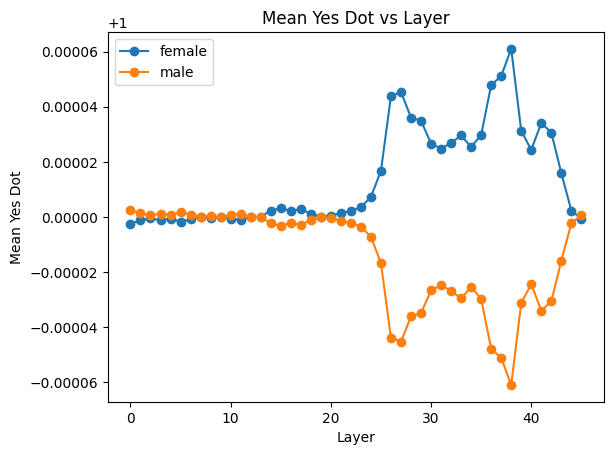

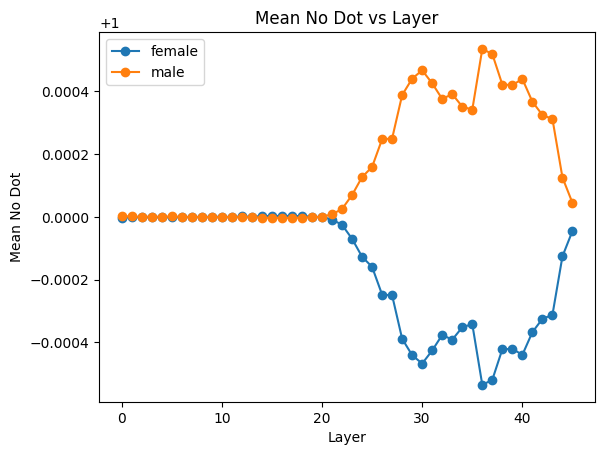



race


Max diff: 0.0009937219066823433 at layer 36


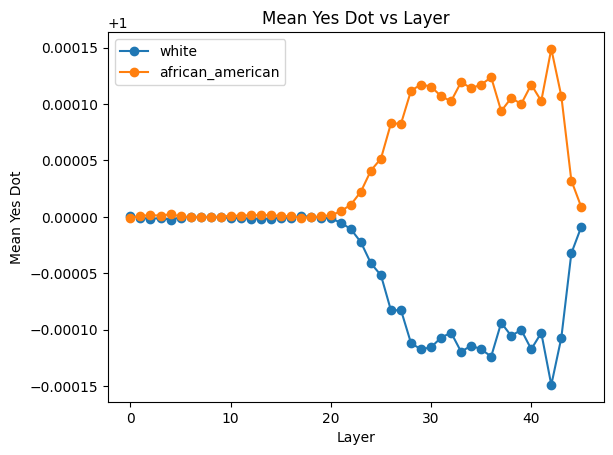

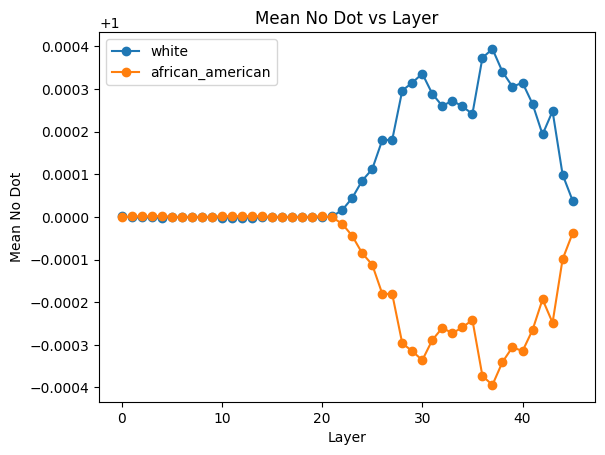



politics


Max diff: 0.003163212628041312 at layer 30


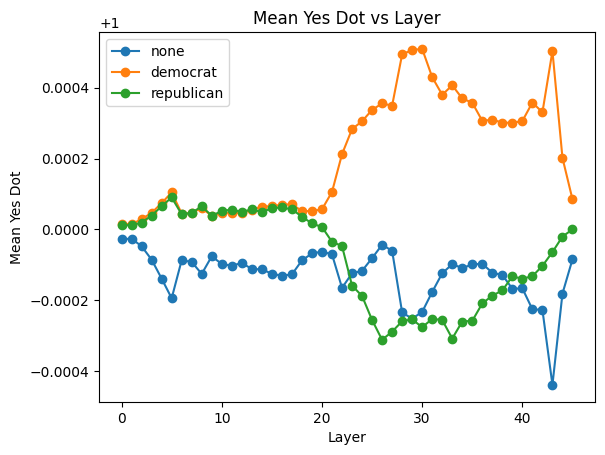

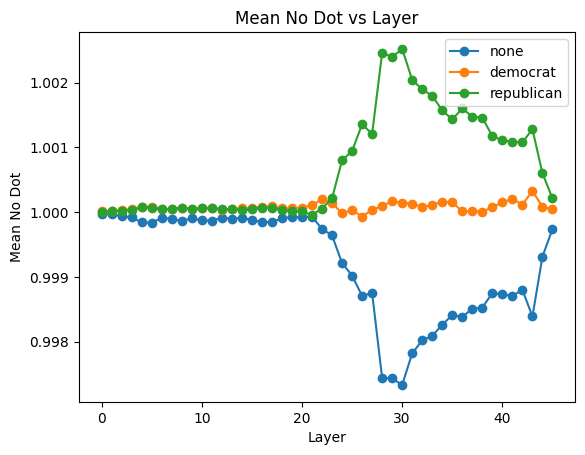

In [7]:
import matplotlib.pyplot as plt

def plot_stats(stats: dict[int, dict[str, dict[str, float]]]):

    layers = sorted(stats.keys())
    classes = stats[layers[0]].keys()

    for metric in ["mean_yes_dot", "mean_no_dot"]:
        plt.figure()
        for g in classes:
            if g == "all":
                continue
            series = [stats[l][g][metric] / stats[l]["all"][metric] for l in layers]
            plt.plot(layers, series, marker="o", label=g)
        plt.xlabel("Layer")
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f"{metric.replace('_', ' ').title()} vs Layer")
        plt.legend()
        # plt.yscale("log")
        plt.show()

def get_max_bias_diff(stats: dict[int, dict[str, dict[str, float]]], bias_type: str) -> float:
    layer_diffs = {}
    for layer in stats:
        layer_diffs[layer] = 0
        for tokens in ["mean_yes_dot", "mean_no_dot"]:
            pos_label = BIAS_DIRECTION_PAIRS[bias_type][0].lower()
            neg_label = BIAS_DIRECTION_PAIRS[bias_type][1].lower()
            diff = abs(stats[layer][pos_label][tokens] / stats[layer]["all"][tokens] - stats[layer][neg_label][tokens] / stats[layer]["all"][tokens])
            layer_diffs[layer] += diff

    max_layer = max(layer_diffs, key=layer_diffs.get)
    max_diff = layer_diffs[max_layer]

    print(f"Max diff: {max_diff} at layer {max_layer}")

    return max_diff



bias_types = ["gender", "race", "politics"]

for bias_type in bias_types:
    print(f"\n\n{bias_type}\n\n")
    stats = layerwise_gender_dotproducts(data, layerwise_yes_vectors, layerwise_no_vectors, bias_type)
    get_max_bias_diff(stats, bias_type)
    plot_stats(stats)

In [12]:



def get_all_diffs(acts_path: str, bias_types: list[str], excluded_versions: list[int]) -> dict[int, dict[str, float]]:

    output_filename = f"{acts_path}_results.json"

    if os.path.exists(output_filename):
        with open(output_filename, "r") as f:
            return json.load(f)

    all_max_diffs = {}
    diff_files = sorted(os.listdir(acts_path))

    all_max_diffs = {} 
    for bias_type in bias_types:
        all_max_diffs[bias_type] = {}

    for diff_file in diff_files:


        if not diff_file.endswith(".pkl"):
            continue

        version_num = diff_file.replace("score_results_v", "").split("_")[0]

        if int(version_num) in excluded_versions:
            continue

        with open(os.path.join(acts_path, diff_file), "rb") as f:
            data = pickle.load(f)

        
        layerwise_yes_vectors, layerwise_no_vectors = layerwise_mean_activations(data)

        for bias_type in bias_types:
            bias_stats = layerwise_gender_dotproducts(data, layerwise_yes_vectors, layerwise_no_vectors, bias_type)
            max_diff = get_max_bias_diff(bias_stats, bias_type)
            all_max_diffs[bias_type][version_num] = max_diff

    with open(output_filename, "w") as f:
        json.dump(all_max_diffs, f)

    return all_max_diffs

model_name = "google_gemma-2-27b-it"
bias_types = ["gender", "race", "politics"]

model_names = ["google_gemma-2-27b-it", "mistralai_Mistral-Small-24B-Instruct-2501", "mistralai_Ministral-8B-Instruct-2410", "google_gemma-2-9b-it"]

for model_name in model_names:

    acts_path = f"all_results/gpu_forward_pass/{model_name}"
    excluded_versions = [20]
    get_all_diffs(acts_path, bias_types, excluded_versions)

{'gender': {'0': 0.0004194067150219416,
  '11': 0.000936368983761926,
  '1': 0.0011666918108721447,
  '3': 0.000511567016524439},
 'race': {'0': 0.0007534603847144661,
  '11': 0.0012267111110386697,
  '1': 0.0009937219066823433,
  '3': 0.000694562959046019},
 'politics': {'0': 0.0017308850141245502,
  '11': 0.002122328882710356,
  '1': 0.003163212628041312,
  '3': 0.0008329054667876035}}